In [2]:
%reload_ext autoreload
%autoreload 2

from ripple_heterogeneity.utils import (
    functions,
    loading,
    batch_analysis,
    add_new_deep_sup,
)
from ripple_heterogeneity.replay import replay_run, influence_of_layer_bias_on_replay
from ripple_heterogeneity.readout import readout_explained_var
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nelpy as nel
import nelpy.plotting as npl
from matplotlib.ticker import AutoMinorLocator
from sklearn.cluster import KMeans
import os
from scipy import stats

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [3]:
# save_path = (
#     r"Z:\home\ryanh\projects\ripple_heterogeneity\readout_explained_var_ripples_extend_50ms_w_pairwise_corr"
# )
# ev_df, pairwise_corr_df = readout_explained_var.load_results(save_path)


In [4]:
# ripple_df = pd.DataFrame()
# for basepath in ev_df.basepath.unique():
#     ripple_df = pd.concat([ripple_df,loading.load_ripples_events(basepath)],ignore_index=True)

In [3]:
df = pd.read_csv(r"Z:\home\ryanh\projects\ripple_heterogeneity\sessions.csv")

region_df = pd.DataFrame()
for basepath in df.basepath:
    brainRegions = loading.load_brain_regions(basepath)
    temp_df = pd.DataFrame()
    temp_df["brainRegions"] = brainRegions.keys()
    temp_df["basepath"] = basepath
    region_df = pd.concat([region_df, temp_df], ignore_index=True)

sessions = region_df[region_df.brainRegions.str.contains("PFC|EC1|EC2|EC3|EC4|EC5|MEC")]
df_sessions = pd.DataFrame()
df_sessions["basepath"] = sessions.basepath.unique()
df_sessions

,basepath
0,Z:\Data\AYAold\AYA7\day19
1,Z:\Data\AYAold\AYA7\day20
2,Z:\Data\AYAold\AYA7\day24
3,Z:\Data\AYAold\AYA7\day25
4,Z:\Data\AYAold\AYA7\day27
...,...
112,Z:\Data\Kenji\i01_maze15_MS.001_004
113,Z:\Data\Kenji\nlx_070329
114,Z:\Data\ORproject\OR18\day1
115,Z:\Data\ORproject\OR18\day2


In [4]:
save_path = (
    r"Z:\home\ryanh\projects\ripple_heterogeneity\ripple_layer_bias_all_ripples_v2"
)

batch_analysis.run(
    df_sessions,
    save_path,
    influence_of_layer_bias_on_replay.run,
    parallel=True,
    overwrite=False,
    verbose=True,
    n_shuffles = 5
)
# load results
df_layer_bias = influence_of_layer_bias_on_replay.load_results(save_path)

100%|██████████| 117/117 [02:32<00:00,  1.31s/it]


In [5]:
df_layer_bias.keys()

Index(['start', 'stop', 'peaks', 'amplitude', 'duration', 'frequency',
       'peakNormedPower', 'detectorName', 'ripple_channel', 'event_spk_thres',
       'basepath', 'basename', 'animal', 'sig_unit_bias', 'n_deep_obs',
       'n_sup_obs', 'n_middle_obs', 'n_deep_sess', 'n_sup_sess',
       'n_middle_sess', 'pval_deep', 'pval_sup', 'pval_middle', 'event_id',
       'balance', 'effective', 'equal', 'ins', 'isns', 'index'],
      dtype='object')

In [6]:
for basepath in df_layer_bias.basepath.unique():
    # basepath = r"Z:\Data\HMC1\day13"
    st, cm = loading.load_spikes(basepath, putativeCellType="Pyr",brainRegion="CA1|PFC|EC1|EC2|EC3|EC4|EC5|MEC")
    cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)

    ripple_epochs = nel.EpochArray(
        np.array(
            [
                df_layer_bias[df_layer_bias.basepath == basepath].start,
                df_layer_bias[df_layer_bias.basepath == basepath].stop,
            ]
        ).T
    )
    # ripples were already extended in the analysis, but we want to 
    # extend them again here to get 150ms after the ripple
    ripple_epochs = ripple_epochs.expand(0.150,direction="stop")
    unit_mat = functions.get_participation(st.data,ripple_epochs.starts, ripple_epochs.stops,par_type="counts")

    if cm.brainRegion.str.contains("PFC").sum() == 0:
        n_pfc_spikes = np.nan
    else:
        n_pfc_spikes = unit_mat[cm.brainRegion.str.contains("PFC"),:].sum(axis=0)

    if cm.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").sum() == 0:
        n_mec_spikes = np.nan
    else:
        n_mec_spikes = unit_mat[cm.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC"),:].sum(axis=0)

    if (cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep")).sum() == 0:
        n_ca1_deep_spikes = np.nan
    else:
        n_ca1_deep_spikes = unit_mat[cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Deep"),:].sum(axis=0)

    if (cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial")).sum() == 0:
        n_ca1_superficial_spikes = np.nan
    else:
        n_ca1_superficial_spikes = unit_mat[cm.brainRegion.str.contains("CA1") & cm.deepSuperficial.str.contains("Superficial"),:].sum(axis=0)
        
    df_layer_bias.loc[df_layer_bias.basepath == basepath, "n_pfc_spikes"] = n_pfc_spikes
    df_layer_bias.loc[df_layer_bias.basepath == basepath, "n_mec_spikes"] = n_mec_spikes
    df_layer_bias.loc[df_layer_bias.basepath == basepath, "n_ca1_deep_spikes"] = n_ca1_deep_spikes
    df_layer_bias.loc[df_layer_bias.basepath == basepath, "n_ca1_superficial_spikes"] = n_ca1_superficial_spikes

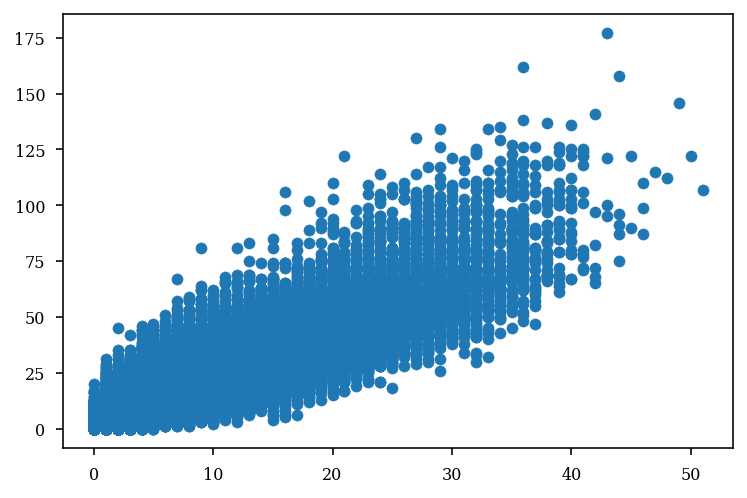

In [7]:
plt.scatter(df_layer_bias.n_deep_obs,df_layer_bias.n_ca1_deep_spikes)

In [8]:
# for basepath in df_layer_bias.basepath.unique():
#     cm = loading.load_cell_metrics(basepath,only_metrics=True)
#     cm = add_new_deep_sup.deep_sup_from_deepSuperficialDistance(cm)
#     df_layer_bias.loc[df_layer_bias.basepath == basepath,"n_deep_all"] = cm.deepSuperficial.str.contains("Deep").sum()
#     df_layer_bias.loc[df_layer_bias.basepath == basepath,"n_sup_all"] = cm.deepSuperficial.str.contains("Superficial").sum()

In [ ]:
# n_cells_over_rip_df = df_layer_bias.groupby("basepath").apply(lambda x: pd.Series({"n_deep":(x.n_deep_obs > 0).sum(),"n_sup":(x.n_sup_obs > 0).sum() })).reset_index()
# # n_cells_df.query("n_sup == 0")
# df_layer_bias.basepath.map(n_cells_over_rip_df[["basepath","n_deep"]])

In [20]:
# df_layer_bias["deep_sup_ratio"] = (
#     df_layer_bias.n_ca1_deep_spikes.values
#     - df_layer_bias.n_ca1_superficial_spikes.values
# ) / (
#     df_layer_bias.n_ca1_deep_spikes.values
#     + df_layer_bias.n_ca1_superficial_spikes.values
# )

df_layer_bias["deep_sup_ratio"] = (
    df_layer_bias.n_deep_obs.values
    - df_layer_bias.n_sup_obs.values
) / (
    df_layer_bias.n_deep_obs.values
    + df_layer_bias.n_sup_obs.values
)

# df_layer_bias["deep_sup_ratio"] = (
#     df_layer_bias.n_deep_obs.values
#     / df_layer_bias.n_sup_obs.values
# )

In [12]:
df_layer_bias.query("deep_sup_ratio == 0").iloc[:,14:]

,n_deep_obs,n_sup_obs,n_middle_obs,n_deep_sess,n_sup_sess,n_middle_sess,pval_deep,pval_sup,pval_middle,event_id,...,ins,isns,index,n_pfc_spikes,n_mec_spikes,n_ca1_deep_spikes,n_ca1_superficial_spikes,n_deep_all,n_sup_all,deep_sup_ratio
14,1,1,0,12,1,3,0.964072,0.095808,1.000000,14,...,-26.479866,-26.479866,NaN,NaN,0.0,3.0,0.0,77.0,13.0,0.0
32,1,1,1,12,1,3,0.990020,0.179641,0.512974,32,...,-12.190538,-12.190538,NaN,NaN,0.0,2.0,0.0,77.0,13.0,0.0
72,1,1,0,12,1,3,0.946108,0.123752,1.000000,72,...,-12.190538,-12.190538,NaN,NaN,0.0,0.0,1.0,77.0,13.0,0.0
84,1,1,0,12,1,3,0.952096,0.111776,1.000000,84,...,-12.190538,-12.190538,NaN,NaN,0.0,3.0,3.0,77.0,13.0,0.0
118,1,1,1,12,1,3,0.998004,0.169661,0.471058,118,...,-51.479866,-51.479866,NaN,NaN,0.0,0.0,1.0,77.0,13.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
407049,4,4,1,24,4,1,1.000000,0.166667,0.500000,3381,...,-17.668799,-17.668799,NaN,15.0,NaN,4.0,6.0,44.0,5.0,0.0
407107,3,3,0,24,4,1,1.000000,0.166667,1.000000,3439,...,-25.390417,-25.390417,NaN,24.0,NaN,5.0,4.0,44.0,5.0,0.0
407109,4,4,0,24,4,1,1.000000,0.166667,1.000000,3441,...,-35.322725,-35.322725,NaN,14.0,NaN,6.0,8.0,44.0,5.0,0.0
407221,1,1,0,24,4,1,1.000000,0.500000,1.000000,3553,...,15.020053,15.020053,NaN,14.0,NaN,3.0,2.0,44.0,5.0,0.0


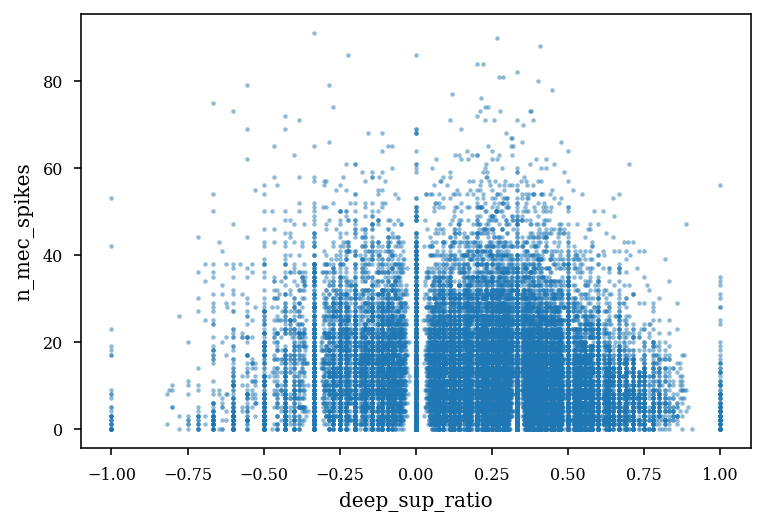

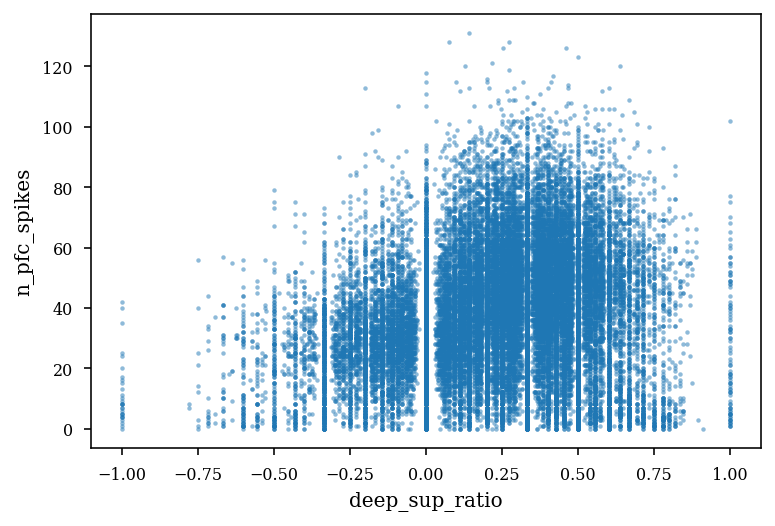

In [22]:
sns.scatterplot(
    x="deep_sup_ratio",
    y="n_mec_spikes",
    data=df_layer_bias.query("n_deep_all > 5 & n_sup_all > 5 & n_ca1_deep_spikes > 5 & n_ca1_superficial_spikes > 5"),
    s=5,
    linewidth=0,
    alpha=0.5,
    legend=False,
)
# plt.xscale("log")
# plt.yscale("log")
plt.show()

sns.scatterplot(
    x="deep_sup_ratio",
    y="n_pfc_spikes",
    data=df_layer_bias.query("n_deep_all > 5 & n_sup_all > 5 & n_ca1_deep_spikes > 5 & n_ca1_superficial_spikes > 5"),
    s=5,
    linewidth=0,
    alpha=0.5,
    legend=False,
)
# plt.xscale("log")
plt.show()

In [ ]:
# df_layer_bias.n_pfc_spikes

sns.scatterplot(
    x="ins",
    y="n_mec_spikes",
    data=df_layer_bias[df_layer_bias.pval_deep < 0.05],
    s=5,
    linewidth=0,
    alpha=0.5,
    legend=False,
)
plt.show()

sns.scatterplot(
    x="ins",
    y="n_pfc_spikes",
    data=df_layer_bias[df_layer_bias.pval_deep < 0.05],
    s=5,
    linewidth=0,
    alpha=0.5,
    legend=False,
)

In [14]:
df_layer_bias[df_layer_bias.pval_deep < 0.05].basepath.value_counts(
    
)

Z:\Data\HMC1\day12                     583
Z:\Data\Kenji\ec014.345_366            490
Z:\Data\Kenji\ec014.171_188            371
Z:\Data\Kenji\ec016.267_278            322
Z:\Data\HMC1\day10                     281
                                      ... 
Z:\Data\Kenji\ec016.100_121              3
Z:\Data\Kenji\ec014.759_779              2
Z:\Data\Kenji\ec013.540_561              1
Z:\Data\Kenji\i01_maze04_MS.001_003      1
Z:\Data\ORproject\OR18\day1              1
Name: basepath, Length: 65, dtype: int64

In [15]:
print(np.sum(df_layer_bias.pval_deep < 0.05),np.sum(df_layer_bias.pval_sup < 0.05),np.sum(df_layer_bias.pval_middle < 0.05))
np.sum(df_layer_bias.pval_deep < 0.05)/df_layer_bias.shape[0],np.sum(df_layer_bias.pval_sup < 0.05)/df_layer_bias.shape[0],np.sum(df_layer_bias.pval_middle < 0.05)/df_layer_bias.shape[0]


5896 4733 9702


(0.014472227608670573, 0.011617546348683484, 0.023814374535163142)

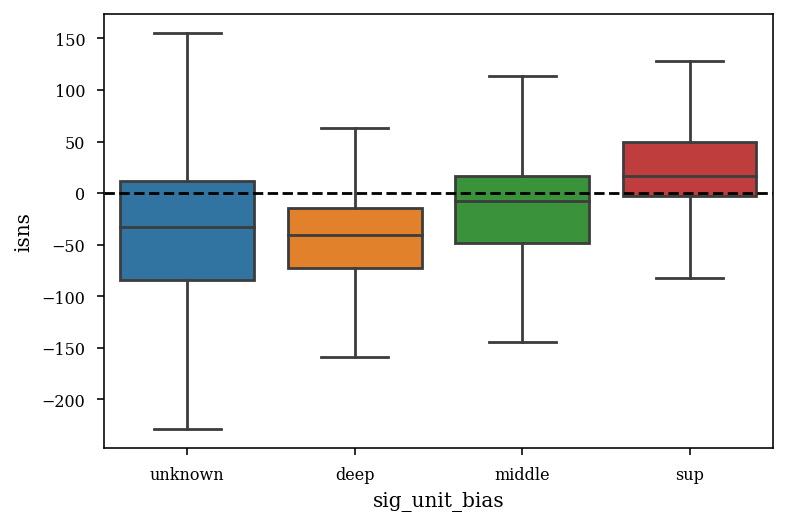

In [16]:
sns.boxplot(x="sig_unit_bias",y="isns",data=df_layer_bias,showfliers=False)
# sns.stripplot(x="sig_unit_bias",y="effective",data=df_layer_bias)
plt.axhline(0,color='k',linestyle='--')
# plt.yscale("log")

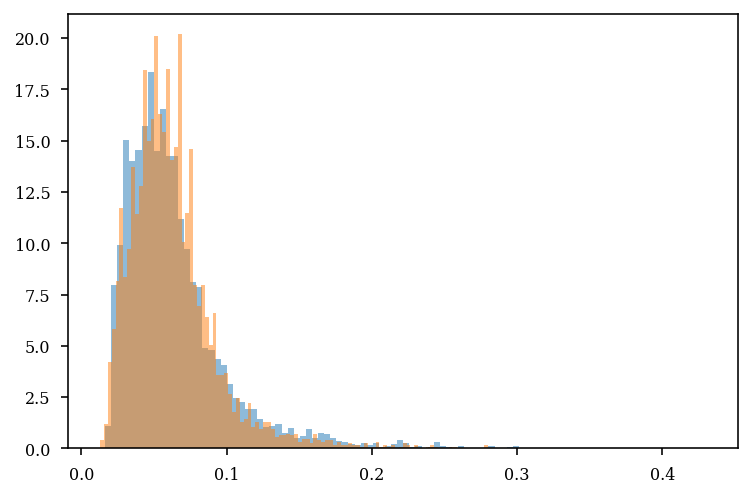

In [18]:
plt.hist(df_layer_bias[df_layer_bias.pval_deep < 0.05].duration,100,density=True,alpha=0.5)
plt.hist(df_layer_bias[df_layer_bias.pval_sup < 0.05].duration,100,density=True,alpha=0.5)
# plt.hist(df_layer_bias[df_layer_bias.pval_middle < 0.05].duration,100,density=True,alpha=0.5)

plt.show()

Text(0.5, 0.98, 'deep')

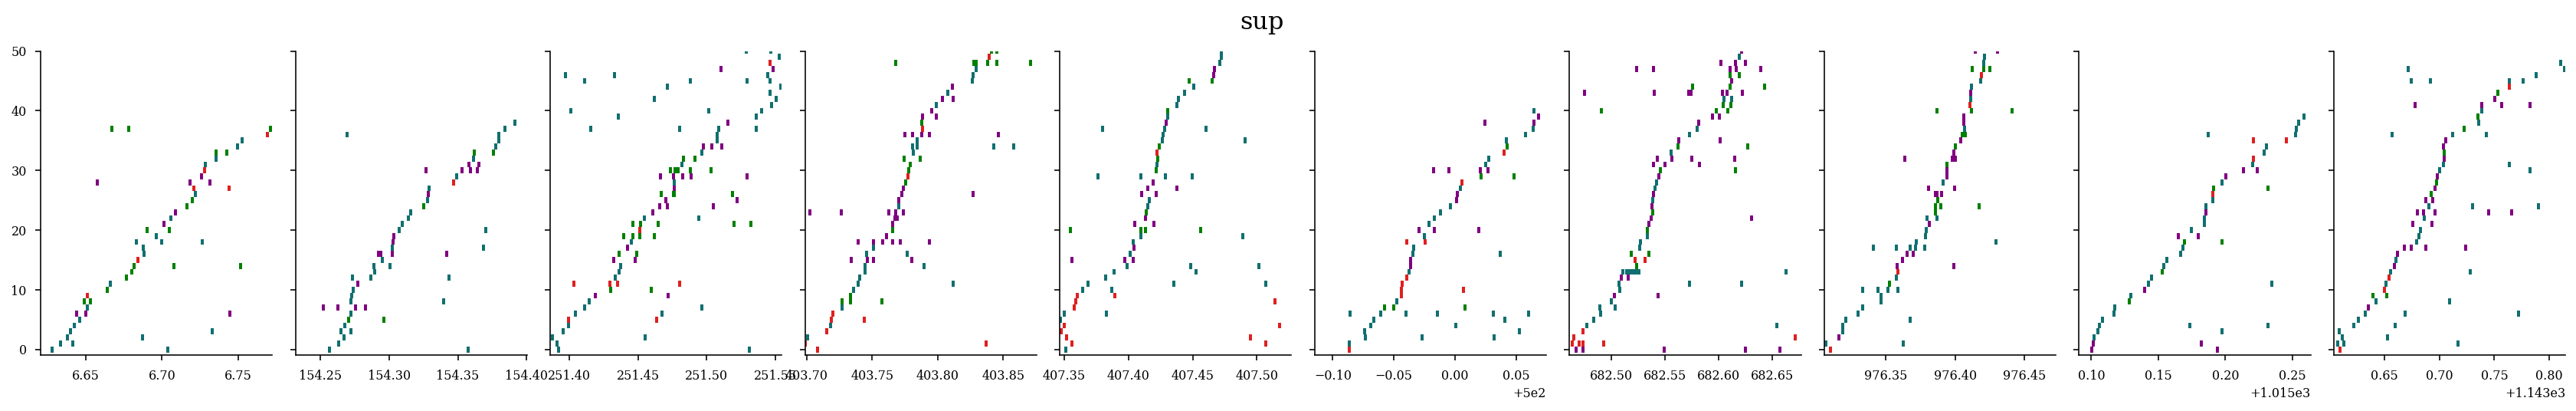

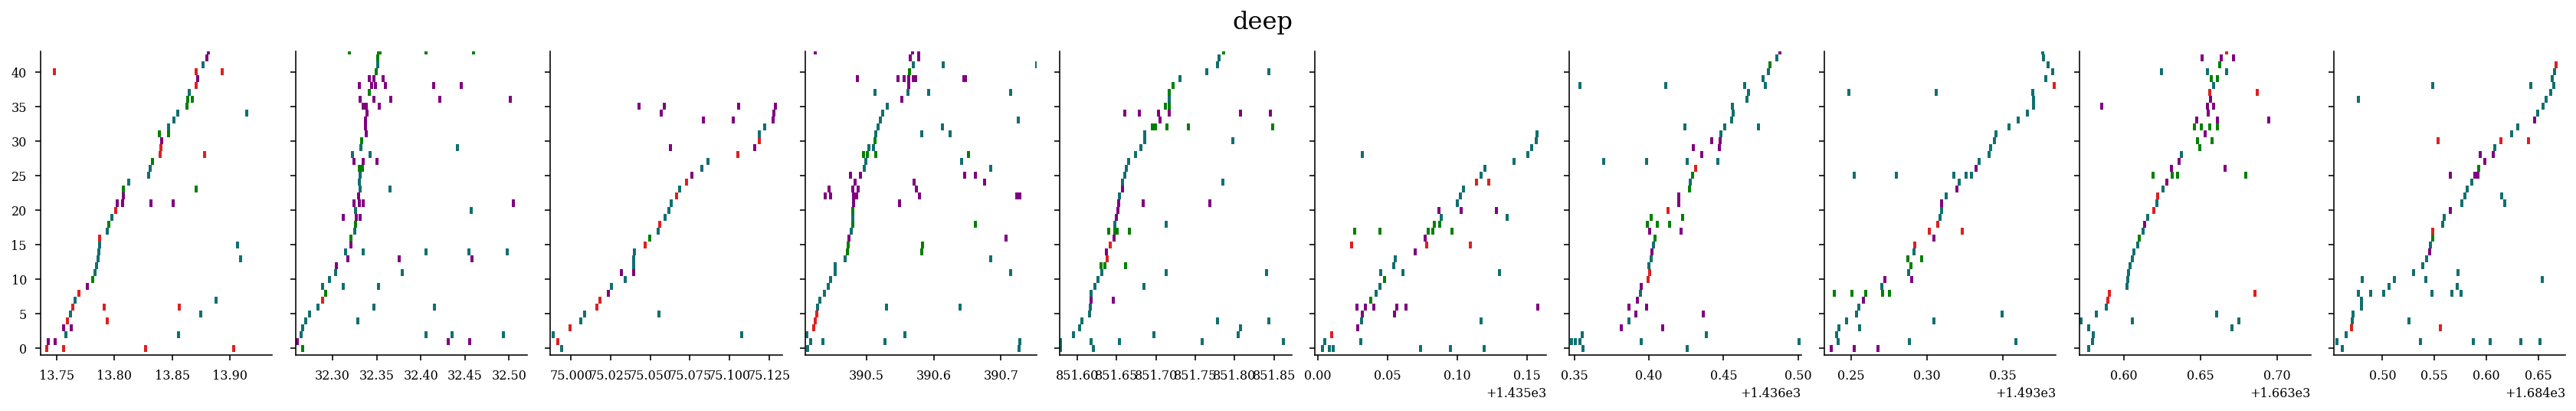

In [19]:
def get_color_code(cell_metrics):
    colors1 = []
    for i in range(len(cell_metrics["deepSuperficial"])):
        if cell_metrics.brainRegion.str.contains("EC1|EC2|EC3|EC4|EC5|MEC").iloc[i]:
            colors1.append("#de2020")
        elif cell_metrics.brainRegion.str.contains("PFC").iloc[i]:
            colors1.append("#116f70")
        elif cell_metrics.deepSuperficial.iloc[i] == "Deep":
            # colors1.append('#7b3294')
            colors1.append("purple")
        elif cell_metrics.deepSuperficial.iloc[i] == "Superficial":
            # colors1.append('#008837')
            colors1.append("green")
        else:
            colors1.append("lightgrey")
    return colors1


def plot_raster_examples(st, replay_canidates, cell_metrics, events):

    if isinstance(events, int):
        n_panels = 1
    else:
        n_panels = len(events)

    figsize = functions.set_size("thesis", fraction=n_panels / 2, subplots=(2, n_panels))
    fig, axs = plt.subplots(
        1,
        n_panels,
        figsize=figsize,
        edgecolor="k",
        sharey=True,
    )
    fig.subplots_adjust(hspace=0.1, wspace=0.1)
    axs = axs.ravel()

    for i, event in enumerate(events):

        # idx = np.where(cell_metrics.brainRegion.str.contains("CA1").values)[0].astype(int)+1

        rank_orders, rank_order_mat = functions.get_rank_order(
            st, replay_canidates[int(event)], method="peak_fr", padding=0
        )
        colors1 = get_color_code(cell_metrics)
        order_idx = np.argsort(rank_orders)

        # order_idx = np.hstack([order_idx,np.arange(order_idx.max()+1,order_idx.max() + cell_metrics.brainRegion.str.contains("MEC").sum())])

        # npl.rasterplot(st.reorder_series_by_ids(order_idx+1)[replay_canidates[int(event)]],ax=axs[i])
        axs[i].eventplot(
            st[replay_canidates[int(event)]].data[order_idx],
            colors=np.array(colors1)[order_idx],
            linelengths=1,
            linewidths=2,
        )
        # dir(st)
        axs[i].set_ylim(-1, st[replay_canidates[int(event)]].n_active + 1)
        axs[i].set_xlim(replay_canidates[int(event)].start, replay_canidates[int(event)].stop)
        sns.despine()
    return fig,axs
# plot_raster_examples(st, replay_canidates, cell_metrics, np.where(temp_df.gmm_labels == "sup")[0][0:10])
# plot_raster_examples(st, replay_canidates, cell_metrics, np.where(temp_df.gmm_labels == "deep")[0][0:10])
# plot_raster_examples(st, replay_canidates, cell_metrics, np.where(temp_df.gmm_labels == "mixed")[0][0:10])

basepath = r"Z:\Data\HMC1\day10"

temp_df = df_layer_bias[(df_layer_bias.basepath == basepath)]
st, cell_metrics = loading.load_spikes(
    basepath, brainRegion=["CA1","PFC","MEC"], putativeCellType="Pyr"
)
# st, cell_metrics = loading.load_spikes(
#     basepath, brainRegion="CA1", putativeCellType="Pyr"
# )
# sup_ripple_epochs = nel.EpochArray(np.array([temp_df[temp_df.gmm_labels == "sup"].start, temp_df[temp_df.gmm_labels == "sup"].stop]).T).expand(0.05).merge()
# deep_ripple_epochs = nel.EpochArray(np.array([temp_df[temp_df.gmm_labels == "deep"].start, temp_df[temp_df.gmm_labels == "deep"].stop]).T).expand(0.05).merge()
# mixed_ripple_epochs = nel.EpochArray(np.array([temp_df[temp_df.gmm_labels == "mixed"].start, temp_df[temp_df.gmm_labels == "mixed"].stop]).T).expand(0.05).merge()
replay_canidates = nel.EpochArray(np.array([temp_df.start, temp_df.stop]).T).expand(0.05).merge()


fig,axs = plot_raster_examples(st, replay_canidates, cell_metrics, np.where((temp_df.sig_unit_bias == "sup"))[0][0:10])
fig.suptitle('sup', fontsize=16)
fig,axs =plot_raster_examples(st, replay_canidates, cell_metrics, np.where((temp_df.sig_unit_bias == "deep" ))[0][0:10])
fig.suptitle('deep', fontsize=16)

# fig,axs =plot_raster_examples(st, replay_canidates, cell_metrics, np.where((temp_df.sig_unit_bias == "middle"))[0][0:10])
# fig.suptitle('middle', fontsize=16)

# fig,axs =plot_raster_examples(st, replay_canidates, cell_metrics, np.where((temp_df.sig_unit_bias == "unknown"))[0][0:10])
# fig.suptitle('unknown', fontsize=16)

In [20]:
np.sum(temp_df.sig_unit_bias == "deep")

292

Text(0.5, 0.98, 'CA1')

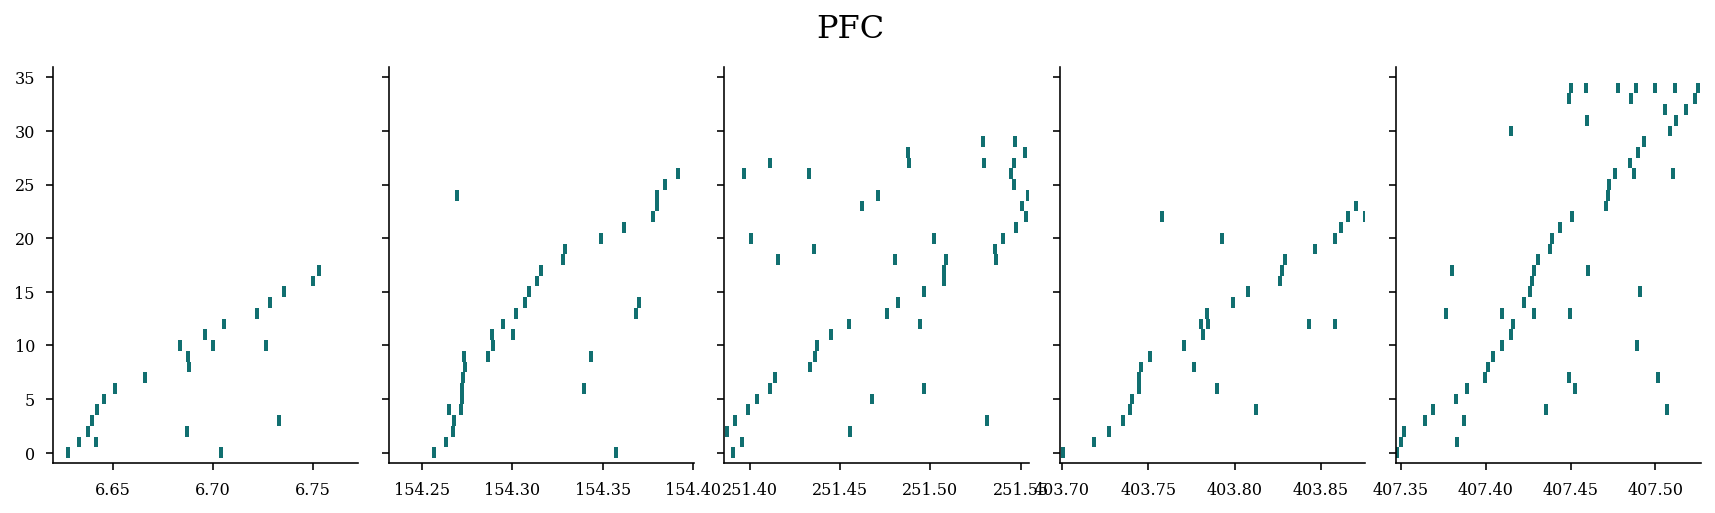

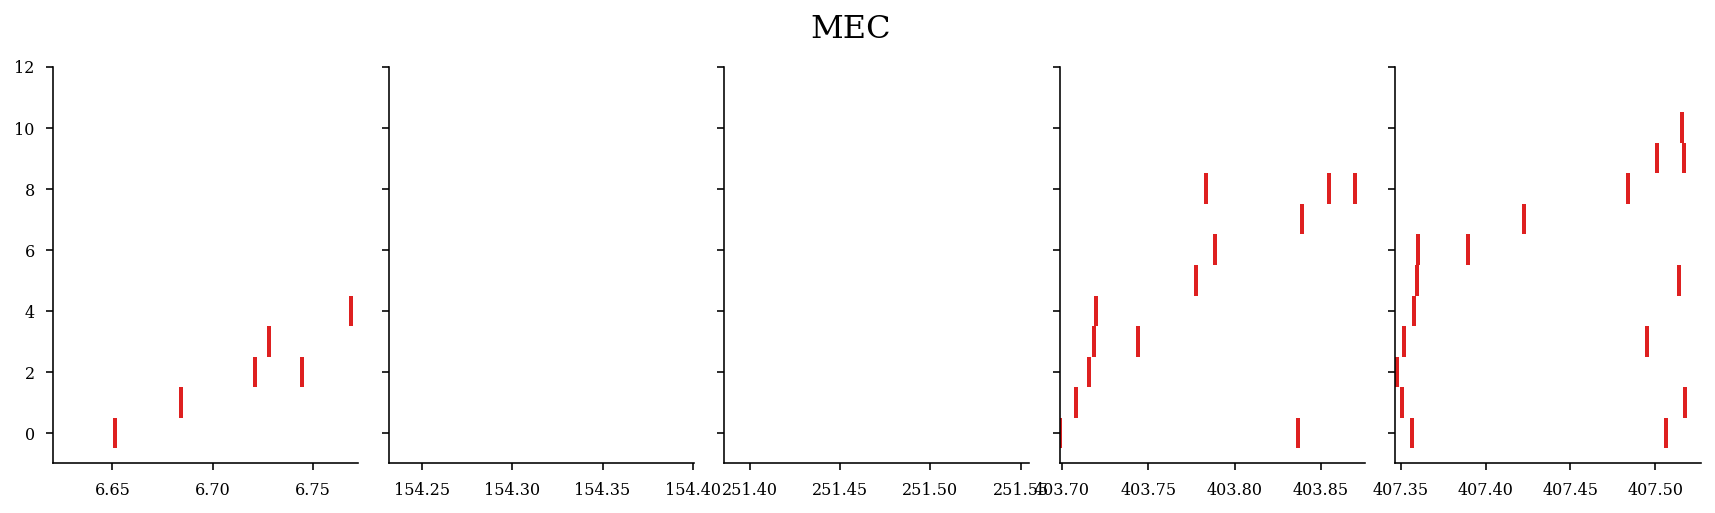

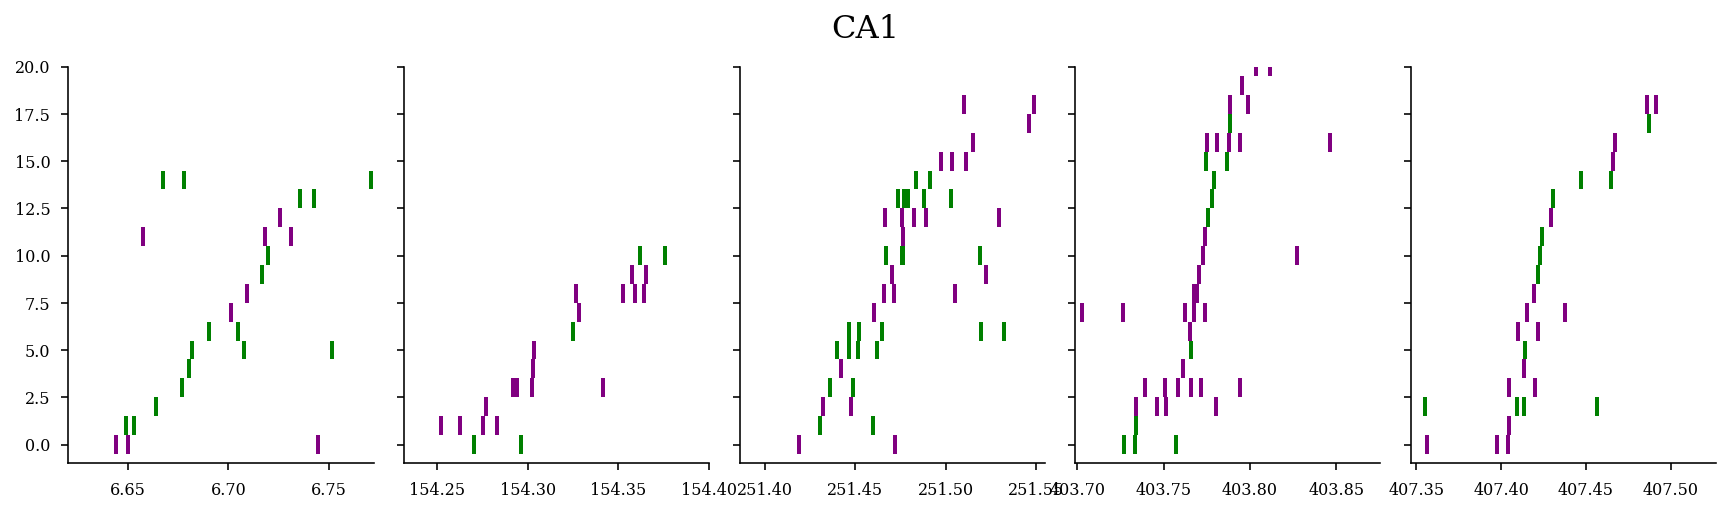

In [21]:
idx = cell_metrics.brainRegion.str.contains("PFC").values
fig,axs = plot_raster_examples(st.iloc[:,idx], replay_canidates, cell_metrics[idx], np.where((temp_df.sig_unit_bias == "sup"))[0][0:5])
fig.suptitle('PFC', fontsize=16)

idx = cell_metrics.brainRegion.str.contains("MEC").values
fig,axs = plot_raster_examples(st.iloc[:,idx], replay_canidates, cell_metrics[idx], np.where((temp_df.sig_unit_bias == "sup"))[0][0:5])
fig.suptitle('MEC', fontsize=16)

idx = cell_metrics.brainRegion.str.contains("CA1").values
fig,axs = plot_raster_examples(st.iloc[:,idx], replay_canidates, cell_metrics[idx], np.where((temp_df.sig_unit_bias == "sup"))[0][0:5])
fig.suptitle('CA1', fontsize=16)

<AxesSubplot:>

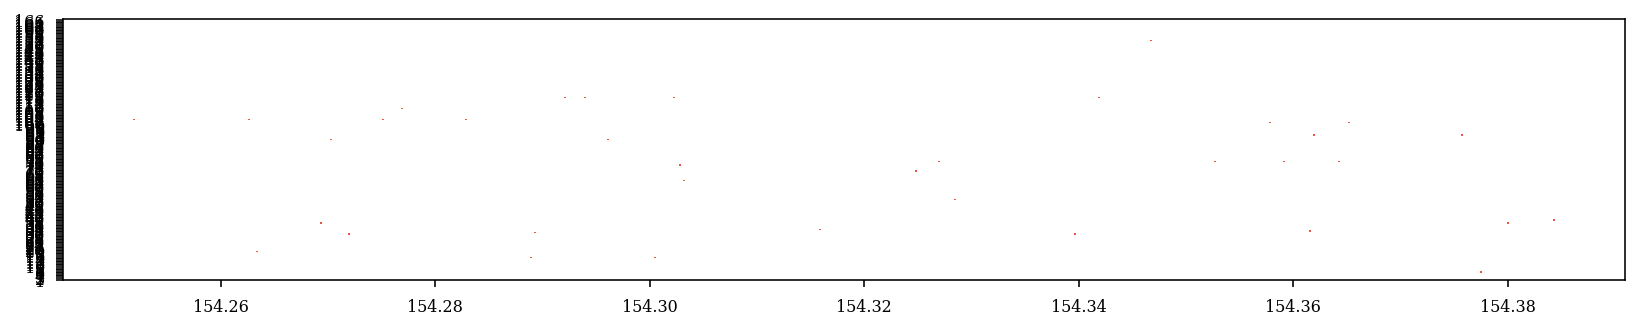

In [40]:
fig, ax = plt.subplots(ncols=1, figsize=(14,2.4))

npl.rasterplot(st[replay_canidates[np.where((temp_df.sig_unit_bias == "sup"))[0][1:2]]], lw=1, ax=ax, color=npl.colors.sweet.red, vertstack=True)

# fig,axs = plot_raster_examples(st, replay_canidates, cell_metrics, np.where((temp_df.sig_unit_bias == "sup"))[0][0:10])
axs[i].eventplot(
    st[replay_canidates[int(event)]].data[order_idx],
    colors=np.array(colors1)[order_idx],
    linelengths=1,
    linewidths=2,
)

In [45]:
np.where((temp_df.sig_unit_bias == "sup"))[0][0:10]

array([  2,  84, 137, 225, 230, 270, 477, 548, 577, 619], dtype=int64)

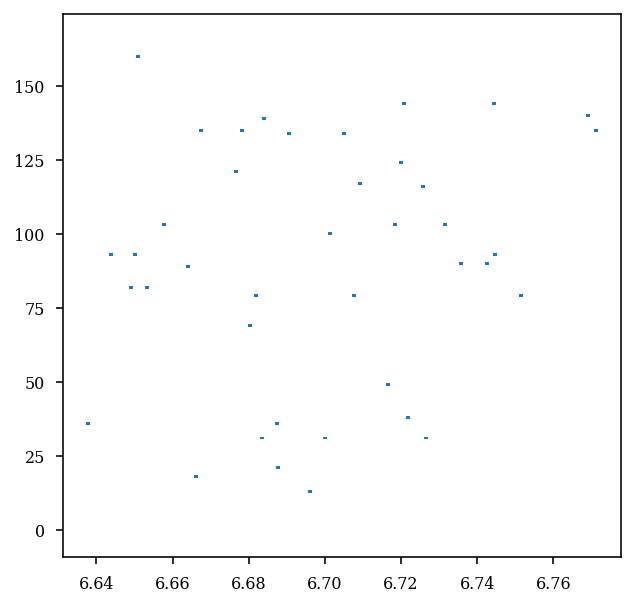

In [52]:
# fig,axs = plot_raster_examples(st, replay_canidates, cell_metrics, np.where((temp_df.sig_unit_bias == "sup"))[0])
plt.figure(figsize=(5,5))
plt.eventplot(st[replay_canidates[2]].data,linelengths=1,
            linewidths=2)
plt.show()